In [1]:
PATCH_SIZE=400
OVERLAP=0.15

GEOTIFF_PATH = "../dataset_marseille/satellite_raster_sample_laplaine_IGN_0.2m-resolution.tif"

OUTPUT_SHAPEFILE = "../dataset_marseille/deepforest_pred_laplaine_IGN0.2m_patch400px_overlap0.15_nonmax0.15.shp"

# Based on case study french Guyana ipython 

see : https://github.com/weecology/DeepForest/blob/master/docs/case_study_FrenchGuiana.md

In [2]:
#Load packages
import numpy as np
from PIL import Image
import os
from matplotlib import pyplot as plt
%matplotlib inline

#Load deepforest
#Optional comet_ml for tracking experiments
# from comet_ml import Experiment
from deepforest import deepforest
from deepforest import preprocess
from deepforest import utilities
from deepforest import __version__
#Geospatial packages
import shapely
import geopandas
import rasterio

#Check version
print("This demo is run with deepforest version {}".format(__version__))

Using TensorFlow backend.


This demo is run with deepforest version 0.3.4


In [24]:
%load_ext autoreload
%autoreload 1
%aimport functions

In [3]:
raster_path = GEOTIFF_PATH
raster = Image.open(raster_path)
numpy_image = np.array(raster)
numpy_image.shape

(3157, 5182, 4)

In [4]:
def bgr2rgb(numpy_image):
    return numpy_image[...,::-1]

In [5]:
# in my case the image has 4 channels, which deepforest complains about
# we drop the alpha channel
numpy_image = numpy_image[:,:,:3]

# Change from RGB to BGR channel order
# Matplotlib and OpenCV differ in default channel orders. 
# Using Image.open will yield RGB images, whereas keras-retinanet expects BGR images. 

numpy_image = numpy_image[...,::-1]  #keras-retinanet requires bluegreered channel order

In [6]:
windows = preprocess.compute_windows(numpy_image, patch_size=PATCH_SIZE,patch_overlap=OVERLAP)

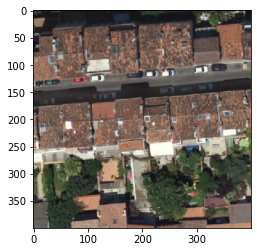

In [7]:
index = 125

crop = numpy_image[windows[index].indices()]
crop.shape

plt.imshow(bgr2rgb(crop))

## Load model 

In [8]:
model = deepforest.deepforest()
model.use_release()

Reading config file: C:\Users\matth\scoop\apps\miniconda3\current\envs\deepforest\lib\site-packages\deepforest\data\deepforest_config.yml
A blank deepforest object created. To perform prediction, either train or load an existing model.
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/v0.3.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/v0.3.0

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Predict

In [9]:
# XXX mtourne: no longer need, done on the whole image
# crop = crop[...,::-1] #keras-retinanet requires bluegreered channel order

prediction = model.predict_image(numpy_image = crop,return_plot=True, score_threshold=0.05)

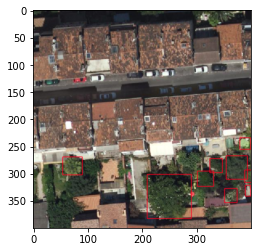

In [10]:
plt.imshow(bgr2rgb(prediction)) #show in rgb channel order

## Predict entire tile

The overall tile is too large to fit into memory. DeepForest will slide overlapping windows, same as the sized above, make a prediction on each window. Then reassemble and delete overlaps based on the highest scoring box. The reassembling process can be subtle, and requires the user to balance the amount of overlap (more predictions = slower), and the overall size of objects on interest.

In [30]:
predicted_boxes = functions.process_tile_windows(model, numpy_image, windows)

100%|████████████████████████████████████████████████████████████████████████████████| 160/160 [05:02<00:00,  1.89s/it]


In [14]:
boxes_iou_threshold0_15 = functions.nonmax_suppression(predicted_boxes, iou_threshold=0.15)

1434 predictions in overlapping windows, applying non-max supression
931 predictions kept after non-max suppression


In [15]:
# results without nonmax suppression are terrible, 
# the nonmax suppressed version becomes the predicted boxes from now on
predicted_boxes = boxes_iou_threshold0_15

## Draw boxes all on a tile

(turned off )

In [19]:
# original_image = functions.bgr2rgb(numpy_image)
# tile = functions.draw_all_boxes(original_image, predicted_boxes)

In [20]:
# fig = plt.figure(figsize=(100,100))
# plt.imshow(tile)

## Save box predictions

### to a csv file

In [21]:
predicted_boxes.to_csv("../dataset_marseille/deepforest_pred_laplaine_boxes-IGN0.2m_patch400px_overlap0.15.csv")

### to a Shapefile (for import in QGIS)

In [48]:
def save_boxes_to_shp_file(raster_path, boxes, output_path):
    raster_projection = functions.RasterProject(raster_path)
    
    boxes = raster_projection.project_boxes(boxes)
    
    # combine column to a shapely Box() object, save shapefile
    boxes['geometry'] = boxes.apply(lambda x: shapely.geometry.box(x.xmin,x.ymin,x.xmax,x.ymax), axis=1)
    boxes = geopandas.GeoDataFrame(boxes, geometry='geometry')
    
    functions.save_shapefile(output_path, boxes)
    return boxes

In [41]:
save_boxes_to_shp_file(GEOTIFF_PATH, predicted_boxes, OUTPUT_SHAPEFILE)

In [49]:
projected_boxes = save_boxes_to_shp_file(GEOTIFF_PATH, predicted_boxes, "test.shp")
projected_boxes

C:\Users\matth\scoop\apps\miniconda3\current\envs\deepforest\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,xmin,ymin,xmax,ymax,score,label,geometry
0,599189.737998,5.357224e+06,599198.872229,5.357215e+06,0.520266,Tree,"POLYGON ((599198.872 5357223.540, 599198.872 5..."
1,599202.189401,5.357227e+06,599210.748590,5.357218e+06,0.488496,Tree,"POLYGON ((599210.749 5357227.351, 599210.749 5..."
2,599187.573678,5.357289e+06,599204.901246,5.357273e+06,0.487912,Tree,"POLYGON ((599204.901 5357289.012, 599204.901 5..."
3,599176.760990,5.357220e+06,599185.233413,5.357213e+06,0.424842,Tree,"POLYGON ((599185.233 5357219.896, 599185.233 5..."
4,599170.300197,5.357287e+06,599185.032679,5.357271e+06,0.372086,Tree,"POLYGON ((599185.033 5357286.614, 599185.033 5..."
...,...,...,...,...,...,...,...
1,600100.522944,5.356709e+06,600104.073580,5.356706e+06,0.265021,Tree,"POLYGON ((600104.074 5356709.335, 600104.074 5..."
2,600125.688830,5.356686e+06,600132.354565,5.356681e+06,0.221464,Tree,"POLYGON ((600132.355 5356685.886, 600132.355 5..."
3,600154.440854,5.356672e+06,600161.523104,5.356669e+06,0.206185,Tree,"POLYGON ((600161.523 5356672.132, 600161.523 5..."
0,600153.913875,5.356690e+06,600169.169074,5.356677e+06,0.645599,Tree,"POLYGON ((600169.169 5356690.342, 600169.169 5..."
